In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import torchaudio
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt



In [2]:
def load_process(path):
    df = pd.read_csv(f'{path}/dem-info.csv')
    # fix 66* string value in Age column
    df['Age'] = df['Age'].apply(lambda x: x.replace('66*', '66'))
    df['Age'] = df['Age'].astype(int)

    # get_file_names
    for ext in ["CTD", "PFT", 'SFT']:
        df[f'{ext}_wav'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'__{ext}.wav'
        df[f'{ext}_txt'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'__{ext}.txt'

    return df

def load_process_cleaned(path):
    df = pd.read_csv(f'{path}/dem-info.csv')
    # fix 66* string value in Age column
    df['Age'] = df['Age'].apply(lambda x: x.replace('66*', '66'))
    df['Age'] = df['Age'].astype(int)

    # get_file_names
    for ext in ["CTD", "PFT", 'SFT']:
        df[f'{ext}_wav'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'_{ext}_clean.wav'
        df[f'{ext}_txt'] = f'{path}/' + df['Record-ID'] + '/' + df['Record-ID'] + f'_{ext}.txt'

    return df

process_path = './data/PROCESS-V1'
df = load_process(process_path)
df_clean = load_process_cleaned(process_path)

In [3]:
w2v2processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')
w2v2model = Wav2Vec2Model.from_pretrained('facebook/wav2vec2-base-960h')

def extract_wav2vec_features(wav_path):
    waveform, sample_rate = torchaudio.load(wav_path)
    inputs = w2v2processor(waveform.squeeze(), sampling_rate=sample_rate, return_tensors='pt', padding=True)
    with torch.no_grad():
        outputs = w2v2model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# df_train_w2v_ctd = [extract_wav2vec_features(a) for a in tqdm(df['CTD_wav'].values)]
# np.savetxt('./data/features/process-ctd-w2v-feature.csv', df_train_w2v_ctd, delimiter=',')
# df_train_w2v_pft = [extract_wav2vec_features(a) for a in tqdm(df['PFT_wav'].values)]
# np.savetxt('./data/features/process-pft-w2v-feature.csv', df_train_w2v_pft, delimiter=',')
# df_train_w2v_sft = [extract_wav2vec_features(a) for a in tqdm(df['SFT_wav'].values)]
# np.savetxt('./data/features/process-sft-w2v-feature.csv', df_train_w2v_sft, delimiter=',')

# df_train_w2v_ctd_clean = [extract_wav2vec_features(a) for a in tqdm(df_clean['CTD_wav'].values)]
# np.savetxt('./data/features/process-ctd-w2v-feature-clean.csv', df_train_w2v_ctd_clean, delimiter=',')
# df_train_w2v_pft_clean = [extract_wav2vec_features(a) for a in tqdm(df_clean['PFT_wav'].values)]
# np.savetxt('./data/features/process-pft-w2v-feature-clean.csv', df_train_w2v_pft_clean, delimiter=',')
# df_train_w2v_sft_clean = [extract_wav2vec_features(a) for a in tqdm(df_clean['SFT_wav'].values)]
# np.savetxt('./data/features/process-sft-w2v-feature-clean.csv', df_train_w2v_sft_clean, delimiter=',')

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
ctd_features = pd.read_csv("./data/features/process-ctd-w2v-feature.csv", header=None)
pft_features = pd.read_csv("./data/features/process-pft-w2v-feature.csv", header=None)
sft_features = pd.read_csv("./data/features/process-sft-w2v-feature.csv", header=None)
ctd_features_clean = pd.read_csv("./data/features/process-ctd-w2v-feature-clean.csv", header=None)
pft_features_clean = pd.read_csv("./data/features/process-pft-w2v-feature-clean.csv", header=None)
sft_features_clean = pd.read_csv("./data/features/process-sft-w2v-feature-clean.csv", header=None)

features = pd.concat([ctd_features, pft_features, sft_features], axis=1, ignore_index=False)
features_clean = pd.concat([ctd_features_clean, pft_features_clean, sft_features_clean], axis=1, ignore_index=False)

In [40]:
y, string_classes = pd.factorize(df['Class'])
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)
X_train_clean, X_test_clean, _, _ = train_test_split(features_clean, y, test_size=0.2, random_state=42)

X_tensor_train = torch.tensor(X_train.values, dtype=torch.float32)
X_tensor_train_clean = torch.tensor(X_train_clean.values, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train, dtype=torch.long)

In [41]:
dataset = TensorDataset(X_tensor_train, y_tensor_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


train_model = True

class FCNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FCNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

if train_model:
    model = FCNN(input_dim=2304, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(10000):
        for batch in dataloader:
            X_batch, y_batch = batch
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    model_save_path = "./models/fcnn_model.pth"
    torch.save(model.state_dict(), model_save_path)


model.eval()
X_tensor_test = torch.tensor(X_test.values , dtype=torch.float32)

with torch.no_grad():
    outputs = model(X_tensor_test)

_, fcnn_pred = torch.max(outputs, 1)



Epoch 1, Loss: 0.9383425116539001
Epoch 2, Loss: 0.9469164609909058
Epoch 3, Loss: 1.049392819404602
Epoch 4, Loss: 1.110471487045288
Epoch 5, Loss: 0.945584237575531
Epoch 6, Loss: 1.013113260269165
Epoch 7, Loss: 0.995297372341156
Epoch 8, Loss: 0.8729528188705444
Epoch 9, Loss: 1.0283052921295166
Epoch 10, Loss: 0.9218342900276184
Epoch 11, Loss: 0.8733711242675781
Epoch 12, Loss: 0.9176133275032043
Epoch 13, Loss: 0.7399699687957764
Epoch 14, Loss: 0.7904554009437561
Epoch 15, Loss: 0.8799133896827698
Epoch 16, Loss: 1.027345895767212
Epoch 17, Loss: 0.8256028890609741
Epoch 18, Loss: 0.797537624835968
Epoch 19, Loss: 0.8901771306991577
Epoch 20, Loss: 1.1069375276565552
Epoch 21, Loss: 0.9194551110267639
Epoch 22, Loss: 0.8202772736549377
Epoch 23, Loss: 0.8075173497200012
Epoch 24, Loss: 0.7968696355819702
Epoch 25, Loss: 0.6802234053611755
Epoch 26, Loss: 0.7398520112037659
Epoch 27, Loss: 0.6633753180503845
Epoch 28, Loss: 0.629361093044281
Epoch 29, Loss: 0.7708480358123779
Ep

In [42]:
dataset_clean = TensorDataset(X_tensor_train_clean, y_tensor_train)
dataloader_clean = DataLoader(dataset_clean, batch_size=32, shuffle=True)

train_model_clean = True

if train_model_clean:
    model_clean = FCNN(input_dim=2304, num_classes=3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(10000):
        for batch in dataloader:
            X_batch, y_batch = batch
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

    model_save_path = "./models/fcnn_model_clean.pth"
    torch.save(model.state_dict(), model_save_path)

model_clean.eval()

with torch.no_grad():
    outputs = model_clean(X_tensor_test)

_, fcnn_pred_clean = torch.max(outputs, 1)

Epoch 1, Loss: 0.03250979632139206
Epoch 2, Loss: 0.013820089399814606
Epoch 3, Loss: 0.005134794861078262
Epoch 4, Loss: 0.010498721152544022
Epoch 5, Loss: 0.014329127036035061
Epoch 6, Loss: 0.009384190663695335
Epoch 7, Loss: 0.02999163419008255
Epoch 8, Loss: 0.03381725773215294
Epoch 9, Loss: 0.009265594184398651
Epoch 10, Loss: 0.0031754367519170046
Epoch 11, Loss: 0.013063587248325348
Epoch 12, Loss: 0.0008505817386321723
Epoch 13, Loss: 0.0036200156901031733
Epoch 14, Loss: 0.001075754058547318
Epoch 15, Loss: 0.04162897169589996
Epoch 16, Loss: 0.008201838470995426
Epoch 17, Loss: 0.0017694580601528287
Epoch 18, Loss: 0.006780553609132767
Epoch 19, Loss: 0.0009763095295056701
Epoch 20, Loss: 0.0012138054007664323
Epoch 21, Loss: 0.0013469888363033533
Epoch 22, Loss: 0.007897308096289635
Epoch 23, Loss: 0.0013379942392930388
Epoch 24, Loss: 0.007068646140396595
Epoch 25, Loss: 0.011770635843276978
Epoch 26, Loss: 0.031941067427396774
Epoch 27, Loss: 0.006795712746679783
Epoch 

Accuracy: 0.53125
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.40      0.36        10
           1       0.25      0.50      0.33         2
           2       0.75      0.60      0.67        20

    accuracy                           0.53        32
   macro avg       0.44      0.50      0.45        32
weighted avg       0.59      0.53      0.55        32



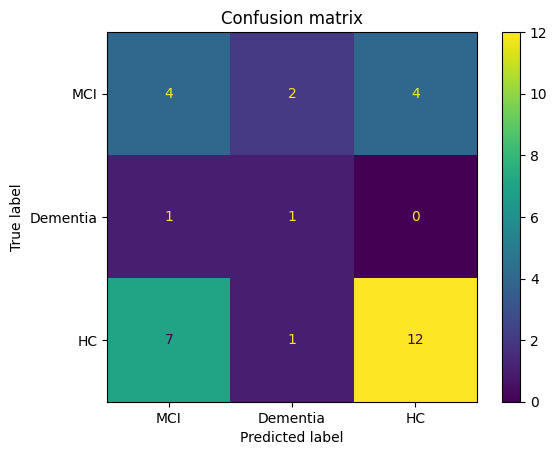

Accuracy: 0.625
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         2
           2       0.62      1.00      0.77        20

    accuracy                           0.62        32
   macro avg       0.21      0.33      0.26        32
weighted avg       0.39      0.62      0.48        32



c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

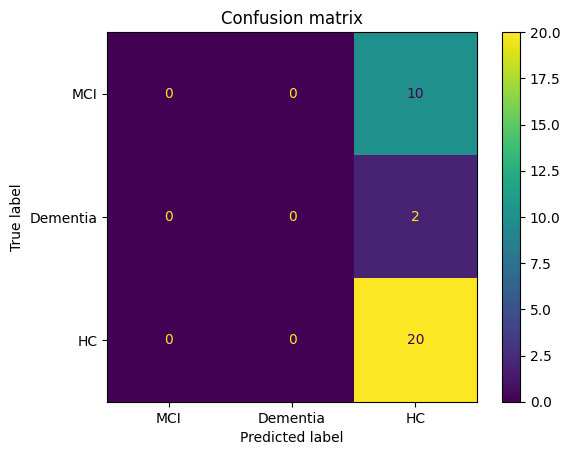

In [43]:
print("Accuracy:", accuracy_score(y_test, fcnn_pred))
print("Classification Report:\n", classification_report(y_test, fcnn_pred))
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, fcnn_pred, labels=range(len(string_classes))), display_labels=string_classes).plot()
cmd.ax_.set_title('Confusion matrix')
plt.show()

print("Accuracy:", accuracy_score(y_test, fcnn_pred_clean))
print("Classification Report:\n", classification_report(y_test, fcnn_pred_clean))
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, fcnn_pred_clean, labels=range(len(string_classes))), display_labels=string_classes).plot()
cmd.ax_.set_title('Confusion matrix')
plt.show()

Accuracy: 0.625
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         2
           2       0.62      1.00      0.77        20

    accuracy                           0.62        32
   macro avg       0.21      0.33      0.26        32
weighted avg       0.39      0.62      0.48        32



c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

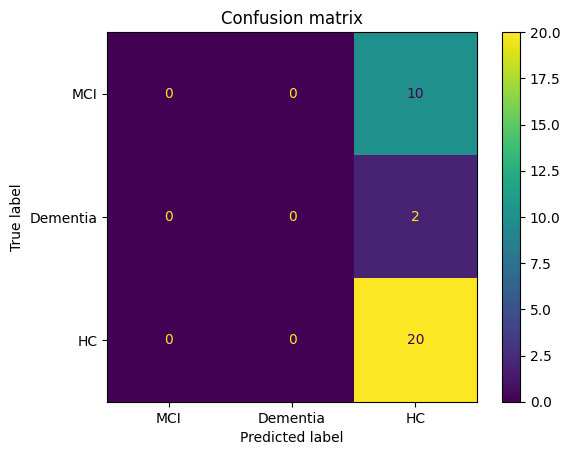

Accuracy: 0.625
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00         2
           2       0.62      1.00      0.77        20

    accuracy                           0.62        32
   macro avg       0.21      0.33      0.26        32
weighted avg       0.39      0.62      0.48        32



c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Christian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

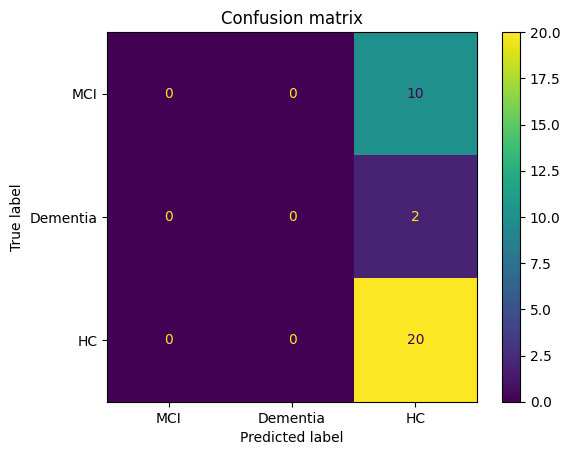

In [37]:
svm_model = SVC(kernel="rbf")
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

svm_model_clean = SVC(kernel="rbf")
svm_model_clean.fit(X_train_clean, y_train)
svm_pred_clean = svm_model.predict(X_test_clean)

print("Accuracy:", accuracy_score(y_test, svm_pred))
print("Classification Report:\n", classification_report(y_test, svm_pred))
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, svm_pred, labels=range(len(string_classes))), display_labels=string_classes).plot()
cmd.ax_.set_title('Confusion matrix')
plt.show()

print("Accuracy:", accuracy_score(y_test, svm_pred_clean))
print("Classification Report:\n", classification_report(y_test, svm_pred_clean))
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, svm_pred_clean, labels=range(len(string_classes))), display_labels=string_classes).plot()
cmd.ax_.set_title('Confusion matrix')
plt.show()